<a href="https://colab.research.google.com/github/takotab/gas-predictor/blob/seq-fastai/notebooks/_v2_seq_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip3 install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
!pip install git+https://github.com/fastai/fastai2

  Cloning https://github.com/fastai/fastai2 to /tmp/pip-req-build-3lxigvxf
  Running command git clone -q https://github.com/fastai/fastai2 /tmp/pip-req-build-3lxigvxf
  Created wheel for fastai2: filename=fastai2-0.0.1-cp37-none-any.whl size=167328 sha256=e34a3bc670de5e312818fbc8bd863ce2791575e5d7661a7ca5d20842ee0c886b
  Stored in directory: /tmp/pip-ephem-wheel-cache-mbcpqgob/wheels/a1/59/9a/50335b36924b827e29d5f40b41fc3a008cc1f30dd80e560dfd
Successfully built fastai2


In [2]:
import fastai2

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import os
import sys
# sys.path.append('..')
# from pathlib import Path
import pandas as pd
import datetime as dt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import seaborn as sns

In [5]:
from fastai2.test import *
from fastai2.core import *
from fastai2.layers import *
from fastai2.data.all import *
from fastai2.optimizer import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.text.core import *
from fastai2.text.data import *
from fastai2.text.models.core import *
from fastai2.text.models.awdlstm import *
from fastai2.callback.rnn import *
from fastai2.callback.all import *

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [151]:
def plot_days(data, ax=None, left=None, right=None, figsize = None, title=None, spacing=.1,  **kwargs):
    from pandas import plotting
    figsize = ifnone(figsize,(20,10))
    if ax is None: _,ax = plt.subplots(figsize=figsize)           
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(left)+len(right))
    for c in left+right:
        if c not in data:
            print(f'Warning{c} not in {data.columns}')
    # First axis
    ax = data.loc[:, left].plot(label=left, color=colors[:len(left)],ax = ax)
    ax.set_ylabel(ylabel=left)
    lines, labels = ax.get_legend_handles_labels()

    for n in range(len(right)):
        # Multiple y-axes 
        if right[n] in data.columns:
            
            ax_new = ax.twinx()
            ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
            data.loc[:, right[n]].plot(ax=ax_new, label=right[n], color=colors[len(left)+n % len(colors)],)
            ax_new.set_ylabel(ylabel=right[n])

            # Proper legend position
            line, label = ax_new.get_legend_handles_labels()
            lines += line
            labels += label

    ax.legend(lines, labels, loc=0)
    if title is not None: ax.set_title(title)
    return ax

In [152]:
from copy import copy 
class Days(CollBase, GetAttr, FilteredBase):
    def __init__(self,df, y_names, cat_var=None, con_var=None,cats={}):
        self.con_var, self.y_names = con_var, y_names                    
        self.df = df
        self.df.set_index('datetime',drop=False,inplace=True)  
        self.cols = ['datetime']+self.con_var
        self.cat_var = ifnone(cat_var,cats.keys())
        if cats == {}:
            self.cats = dict(self.df[self.cat_var].iloc[0])
        else:
            self.cats = cats
        for c in self.cols+self.y_names:
            if c not in self.df.columns:
                print(f'Warning {c} not in {self.df.columns}')
                
    def __repr__(self):
        return str(self.df)
    
    def copy(self):
        # https://stackoverflow.com/questions/17591104/in-pandas-can-i-deeply-copy-a-dataframe-including-its-index-and-column        
        return Days(pd.DataFrame(self.df.values.copy(), self.df.index.copy(), self.df.columns.copy()),self.y_names,self.cat_var,self.con_var)
    
    def repr(self):
        return {'y_names':self.y_names,'cat_var':self.cat_var,'con_var': self.con_var }
    
    def show(self,plot=True,**kwargs):
        
        title= f"{self.cats}  from {str(min(self.df.loc[:,'datetime']))} to {str(max(self.df.loc[:,'datetime']))} #{self.df.shape[0]}"
        print(self.df.columns)
        if plot:
            plot_days(self.df,left=self.con_var,right=self.y_names+['pred'],title=title,**kwargs)
        else:
            return title+'\n'+str(self.df.head(1)   ) 
            
    @classmethod
    def from_intervals(cls,intervals,seq_len,y_names, cat_var, con_var):
        
        cls(_df, y_names, cat_var, con_var)
    

In [153]:
d = Days(pd.DataFrame({'datetime':[pd.Timestamp('2019-01-01')+x*pd.Timedelta('1H') for x in range(24)],
                       'target':np.arange(24),'con':np.arange(24)-2,
                       'cat':[1]*24
                      }),['target'],['cat'],['con'])
_d = d.copy()
d.df['con'] += 4
test_ne(d.df['con'].values,_d.df['con'].values)
d_cat = Days(pd.DataFrame({'datetime':[pd.Timestamp('2019-01-01')+x*pd.Timedelta('1H') for x in range(24)],
                       'target':np.arange(24),'con':np.arange(24)-2,},),
                      ['target'],con_var=['con'], cats ={'cat':1}
                     )
test_eq(d_cat.cats,d_cat.cats)

CPU times: user 4.89 ms, sys: 0 ns, total: 4.89 ms
Wall time: 4.73 ms
Index(['datetime', 'target', 'temp', 'pressure', 'humidity', 'loc', 'city'], dtype='object')
Warningpred not in Index(['datetime', 'target', 'temp', 'pressure', 'humidity', 'loc', 'city'], dtype='object')


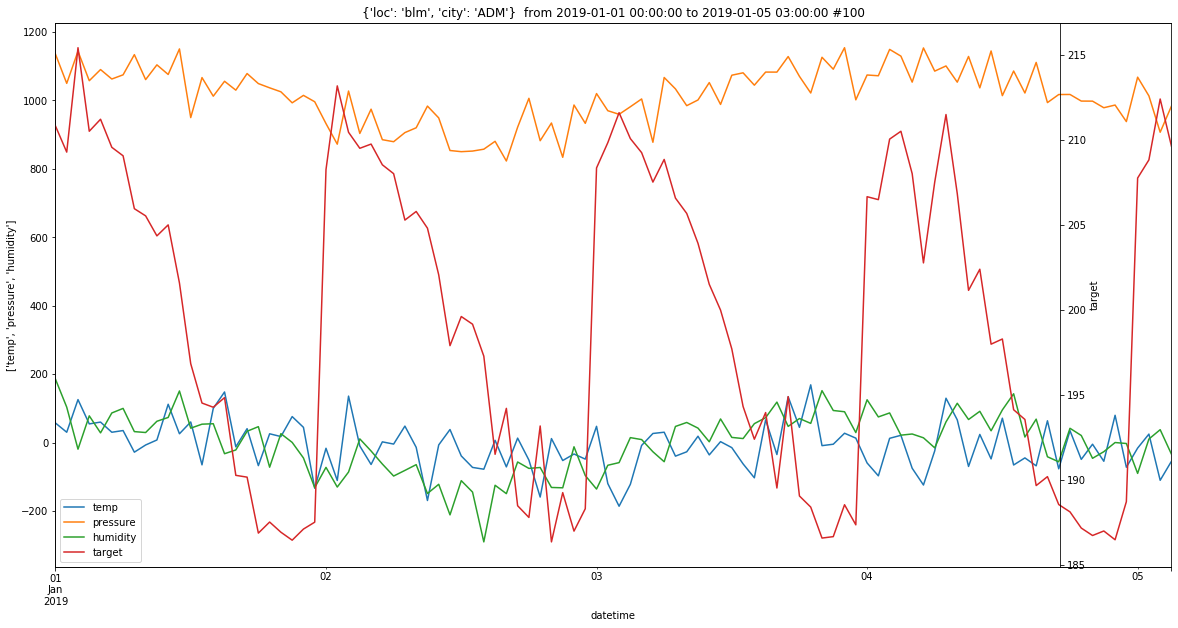

In [154]:
def make_fake_data(num, l=None, locations = 4, jumps = True, chance_of_jump = 0.9):
    locs,citys = ['blm','cnt','rzb','ctl'],['ADM','ADM','ADM','RTD']
    loc_multis = [198,587,999,1660]
    dfs = []
    for i_loc in range(locations):
        loc,city,loc_multi = locs[i_loc], citys[i_loc],loc_multis[i_loc]
        start = pd.Timestamp('2019-01-01')
        for i in range(num):
            l = ifnone(l,100)
            t = i + np.arange(l)/12
            t_dt = [start+pd.Timedelta(hours=x) for x in range(l)]
            pressure = (np.random.randn(l)*.5+np.cos(-t))
            hum = (np.random.randn(l)*.5+np.cos(t))
            temp = np.random.randn(l)*2+np.cos(t)+np.cos(-t/2)
            if city == 'ADM':
                rand = pressure
            else:
                rand = hum                
            _df = pd.DataFrame(data={'datetime':t_dt,
                                'target': loc_multi + temp * rand + 3*np.sin([o.hour/12*3.15 for o in t_dt]) + 10*np.cos([(o.hour/24)*3.15 for o in t_dt]), 
#                                 'pred':np.random.randn(l) * .5 + np.sin(t),                                        
                                'temp':temp*30-5,
                                'pressure':1000+100*pressure,
                                'humidity':hum*100,
                                'loc':[loc]*l,
                                'city':[city]*l})
            assert _df.shape[0] == l
            dfs.append(_df)
            start += pd.Timedelta(hours=l)
            if np.random.rand()> chance_of_jump and jumps:
                start += pd.Timedelta(hours=l*3)   
                start+=(pd.Timedelta('1H')*np.random.choice(np.arange(24)))
            
    return pd.concat(dfs)
%time _df = make_fake_data(1,locations=1)
it = Days(_df,['target'],['loc','city'],['temp','pressure','humidity'])
it.show(figsize=(20,10))

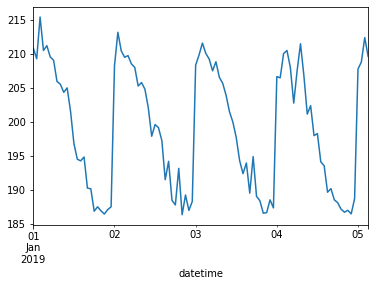

In [155]:
it.df['target'].plot()

In [156]:
df = make_fake_data(100,locations=4)
print(df.shape, min(df.datetime),max(df.datetime))
df.head()

(40000, 7) 2019-01-01 00:00:00 2020-10-24 18:00:00


,datetime,target,temp,pressure,humidity,loc,city
0,2019-01-01 00:00:00,215.645696,179.827655,1124.099878,183.181262,blm,ADM
1,2019-01-01 01:00:00,209.999365,85.054571,1043.536518,85.596460,blm,ADM
2,2019-01-01 02:00:00,208.368904,-35.248162,1078.567832,172.109655,blm,ADM
3,2019-01-01 03:00:00,211.583555,104.453200,1060.930473,90.426220,blm,ADM
4,2019-01-01 04:00:00,207.565347,127.921342,961.853487,94.174984,blm,ADM


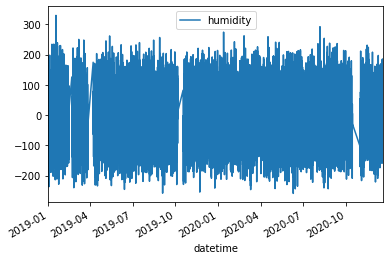

In [157]:
df = make_fake_data(100,locations=2,l=120,jumps=True)
df.index = df.datetime
df[['humidity']].plot()

In [158]:
from copy import copy
def to_elapsed(s):
    return s.astype(np.int64) // 10 ** 9

def remove_last(df,start, end, sz):
    old_start = copy(start)
    start = end - sz + pd.Timedelta(hours = 1)
    return df[start:end], old_start, start
    
def get_not_interval(df, interval, shift = 1):
    df.index = df.datetime
    df = df.sort_index()
    df["delta"] = abs(
        (to_elapsed(df["datetime"]) - to_elapsed(df["datetime"].shift(shift)))
    )
    #     df["delta"] = df['delta'].dt.seconds
    not_hour = df.index[df["delta"] != interval].tolist()
    del df["delta"]
    return not_hour
    

def make_interval(
    df: pd.DataFrame,
    interval=3600,
    sz='72H',
    max_splits=35,
    callback_error=None,
) -> pd.DataFrame:
    """Will check if `df.datetime` has interval of `interval` in seconds. 
    
    if not will make it happen and return a list where this is done.
    """
    starts = get_not_interval(df, interval, 1)
    ends = get_not_interval(df, interval, -1)
    dfs = []
    for start, end in zip(starts,ends):        
        dfs += [df.loc[i:i+pd.Timedelta(sz),:] for i in pd.date_range(start,end,freq=sz) ]       

    return dfs

dfs = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    dfs += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))
lengths =pd.DataFrame({'rows':[dfs[i].df.shape[0] for i in range(len(dfs))]})

In [159]:
[(dfs[i].df, i) for i in range(len(dfs)) if dfs[i].df.isnull().sum().sum()>0]

[]

In [160]:
pd.value_counts(lengths['rows'])

73    318
48      9
72      7
24      7
Name: rows, dtype: int64

In [161]:
df = make_fake_data(100,locations=4,l=100,jumps=True)
items = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    items += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))
    

In [162]:
print('\n'.join([d.show(plot=False) for d in items[[0,-1]][::-1]]))

Index(['datetime', 'target', 'temp', 'pressure', 'humidity', 'loc', 'city'], dtype='object')
Index(['datetime', 'target', 'temp', 'pressure', 'humidity', 'loc', 'city'], dtype='object')
{'city': 'ADM', 'loc': 'blm'}  from 2020-05-20 11:00:00 to 2020-05-22 14:00:00 #52
                               datetime      target       temp    pressure  \
datetime                                                                     
2020-05-20 11:00:00 2020-05-20 11:00:00  200.788237 -50.613388  949.548587   

                      humidity  loc city  
datetime                                  
2020-05-20 11:00:00 -55.012738  blm  ADM  
{'city': 'ADM', 'loc': 'rzb'}  from 2019-01-01 00:00:00 to 2019-01-04 00:00:00 #73
             datetime       target       temp     pressure    humidity  loc  \
datetime                                                                      
2019-01-01 2019-01-01  1009.097987  27.712139  1008.986326  108.357233  rzb   

           city  
datetime         
2019-01-01

In [163]:
def split_idxs(items):
    total = 0
    train_idx, valid_idx, test_idx = [], [], []
    train_idx_s, valid_idx_s, test_idx_s = 0,0,0
    for idx, it in enumerate(items):
        
        ts = it.df['datetime'].iloc[0]
        total += _df.shape[0]
        if  ts.month == 2       :
            if ts.minute == 0:
                test_idx.append(idx)
                test_idx_s += _df.shape[0]

        elif ts.month == 9 or ts.month == 10:
            if ts.minute == 0:
                valid_idx.append(idx)
                valid_idx_s += _df.shape[0]
        else:
            train_idx.append(idx)
            train_idx_s +=_df.shape[0]

    if len(valid_idx) == 0 and len(train_idx):
        valid_idx.append(train_idx.pop(-1))
    if len(test_idx) == 0 and len(train_idx):
        test_idx.append(train_idx.pop(-1))
    print()
    print("Test set length\t\t", test_idx_s / total, test_idx_s)
    print("Validation set length\t", valid_idx_s / total,valid_idx_s)
    print("Train set length\t", train_idx_s / total, train_idx_s)
    print(total, test_idx_s)
    
    return [train_idx, valid_idx, test_idx]

splits = split_idxs(items)


Test set length		 0.09947643979057591 570000
Validation set length	 0.11518324607329843 660000
Train set length	 0.7853403141361257 4500000
5730000 570000


In [164]:
def _to_elapsed(o:int):
    return o // 10 ** 9
def _to_dt(o):
    return o*(10**9)
pd.Timestamp(_to_dt(_to_elapsed(pd.Timestamp('2019-01-01').value)))

Timestamp('2019-01-01 00:00:00')

In [165]:
class Change_dt(Transform):
    def __init__(self, start=None, col='datetime'):
        self.start = ifnone(start, _to_elapsed(pd.Timestamp('2019-01-01').value))
        self.col = col
        
    def encodes(self, o:Days): 
        a = o.copy()
#         if set(o.df.loc[:,'city']) == {0}:
#             print('c dt in:',{c:set(o.df.loc[:,c]) for c in o.cat_var})
#             print(o.df)            
        a.df[self.col] = _to_elapsed(a.df[self.col].astype(int)) - self.start
        return a
    
    def decodes(self, o:Days): 
        o.df[self.col] = pd.to_datetime(_to_dt(o.df[self.col] + self.start))
        o.df.index = o.df[self.col]
        return o

In [166]:
_df = make_fake_data(1,locations=1)
it = Days(_df, ['target'],['loc','city'],['temp','pressure','humidity'])
Dt = Change_dt()
it = Dt(it) 
_ = Dt.decodes(it)
test_eq(it.df, Dt.decode(Dt(it)).df)

In [167]:
class DaysTuple(Tuple):
    def show(self, ctx=None, **kwargs): 
        tensors, catagories = self
        return show_image(torch.cat([img1,img2], dim=2), title=same_breed, ctx=ctx)

In [168]:
class TensorSequence(TensorBase):pass
class Numericalize(Transform):
    "Reversible transform of tokenized cat_var to numericalized ids"
    
    def setup(self, dsrc):
        if dsrc is None: return
        self.item = dsrc[0]
        self.vocab,self.o2i = {},{}
        for cat in self.item.cats.keys():
            count = L()            
            for i in [o.cats[cat] for o in dsrc]:
                count.append(i)
            self.o2i[cat] = {k:int(i) for i,k in enumerate(count.unique() + L(0))}            
            self.vocab[cat] = {v:k for k,v in self.o2i[cat].items()}

    def encodes(self, inp:Days):
        o = inp.copy()
        cats = L()
        for c in self.item.cats:
            cats.append( self.o2i[c][o.cats[c]])
        o.df.loc[24:,self.item.y_names] = 0
        res = o.df.loc[:,self.item.cols].fillna(0).values
        return DaysTuple(TensorSequence(res),Tensor(cats).long())
    
    def decodes(self, inpt:DaysTuple):    
        o = pd.DataFrame(inpt[0].numpy(),columns = self.item.cols)
        cats = {}
        for i,c in enumerate(self.item.cat_var):
            cats[c] = self.vocab[c][int(inpt[1][i])]
        return Days(o,**self.item.repr(),cats=cats)
    
    def get_vocab_sz(self):
        return [len(self.vocab[v]) for v in self.item.cat_var]
    

In [169]:
df = make_fake_data(50,locations=4,l=73,jumps=False)
items = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    items += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))    
num = Numericalize()
num.setup(items)
print(num.o2i['loc'],num.vocab['city'])
test_eq(len(num.vocab['loc']), len(set(df['loc']))+1)
test_eq(len(num.vocab['city']), len(set(df['city']))+1)
test_eq(num.get_vocab_sz(),(len(set(df['city']))+1, len(set(df['loc']))+1))

{'rzb': 0, 'ctl': 1, 'cnt': 2, 'blm': 3, 0: 4} {0: 'ADM', 1: 'RTD', 2: 0}


In [170]:
it = items[-10]
Dt = Change_dt()
_it = num(Dt(it))
test_eq(torch.isnan(_it[0]).sum(),0)
test_eq(type(_it),DaysTuple)
d = Dt.decodes(num.decodes(_it ))
test_eq(type(d),Days)
test_eq(d.df[it.cols],it.df[it.cols])
test_eq(d.cats,it.cats)

Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity'], dtype='object')


In [171]:
class TensorSequenceY(TensorBase):pass

class TargetSequence(pd.DataFrame):
    def show(self, ctx=None,ax=None,figsize=None, **kwargs): 
        y = self
        figsize = ifnone(figsize,(20,10))
        if ax is None: _,ax = plt.subplots(figsize=figsize)
        ax.plot(y)
        return ax
        
class Label(Transform):    
    def setup(self, dsrc):
        if dsrc is None: return
        self.item = dsrc[0]
        
    def encodes(self, o:Days): 
        return TensorSequenceY(tensor(o.df[self.item.y_names].copy().values))
    
    def decodes(self, o:TensorSequenceY):         
        o = pd.DataFrame(o.numpy(),columns = self.item.y_names )
        return TargetSequence(o)
    

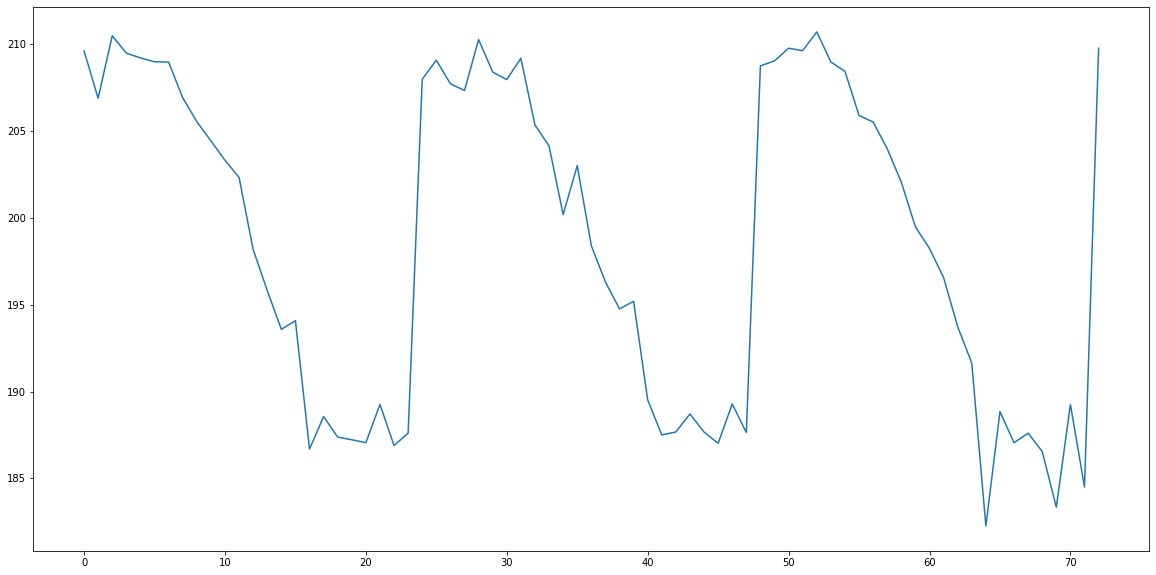

In [172]:
df = make_fake_data(10,locations=1,l=73,jumps=False)
items = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    items += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))    
lab = Label()
lab.setup(items[:10])
test_eq(lab(items[1]).shape,(73,1))
test_eq(lab.decodes(lab(items[0])).shape, (73, 1))
lab.decodes(lab(items[0])).show()

In [173]:
class SeqLen(Transform):
    def __init__(self,len=73):
        self.len = len
        
    def encodes(self, o:TensorBase):   
        a = torch.zeros(self.len,o.shape[1])
        _len = min([self.len,o.shape[0]])
        a[:_len,:] = o[:_len,:]
        return a
    
    def encodes(self, inpt:DaysTuple):   
        o, cats = inpt
        a = self.encodes(o)
        return DaysTuple(a, cats)
    
    
    def decodes(self, o):
        return o
    

In [174]:
seqlen = SeqLen(73)
test_eq(seqlen(TensorSequenceY(np.random.rand(50,3))).shape,(73,3))
test_eq(seqlen(TensorSequenceY(np.random.rand(50,8))).shape,(73,8))

In [175]:
del seqlen
seqlen = SeqLen(10)
test_eq(seqlen(TensorSequenceY(np.random.rand(50,3))).shape,(10,3))

In [176]:
d = DaysTuple(TensorBase(np.random.rand(50,3)),{"a":1})
test_eq(seqlen(d)[0].shape,(10,3))
test_eq(seqlen(d)[1],{"a":1})

In [177]:
class Normalize(Transform):   
    def __init__(self, norm_cols= None):
        self.norm_cols = norm_cols
        
    def setup(self, dsrc):
        if dsrc is None: return
        if self.norm_cols == None:
            self.norm_cols = range(dsrc[0][0].shape[-1])
        its = torch.cat([o[0][None,:,self.norm_cols] for o in dsrc])
        self.m,self.s = Tensor([0]*dsrc[0][0].shape[-1]),Tensor([1]*dsrc[0][0].shape[-1])
        self.m[self.norm_cols],self.s[self.norm_cols] = its.mean((0,1)),its.std((0,1))+1e-5
        
    def encodes(self, inpt):
        o,cats = inpt
        o = (o-self.m)/self.s
        return DaysTuple(o,cats)
        
    
    def decodes(self, inpt):   
        o,cats = inpt      
        o= (o*self.s)+self.m
        return DaysTuple(o,cats)
    

In [178]:
a = np.array([[1+np.arange(7)]*73]*100)*(1+.3*np.random.randn(100,73,7))
# a[:,:,6] = 3.14
print(a.shape)
b = Tensor(a)
(b.mean((0,1)),b.std((0,1)))

(100, 73, 7)


(tensor([1.0060, 1.9983, 2.9990, 3.9832, 4.9955, 6.0171, 7.0031]),
 tensor([0.3023, 0.6056, 0.9037, 1.2018, 1.4941, 1.8088, 2.0760]))

In [179]:
norm = Normalize(range(6))
its = Tensor()
norm.setup([(Tensor(a[i]),{}) for i in range(a.shape[0])])
print(norm.m,norm.s)
test_close(norm.m, Tensor([1,2,3,4,5,6,0]),0.1)
test_close(norm.s,Tensor([.3,.6,.9,1.2,1.5,1.8,1]),0.1)

tensor([1.0060, 1.9983, 2.9990, 3.9832, 4.9955, 6.0171, 0.0000]) tensor([0.3023, 0.6056, 0.9037, 1.2018, 1.4941, 1.8088, 1.0000])


In [180]:
res = norm((Tensor(a),{'foo':'bar'}))
test_close(res[0].mean((0,1)),Tensor([0]*6 + [7]),0.1)
test_close(res[0].std((0,1)),Tensor([1]*6+[2.1]),0.1)

In [181]:
a_res = norm.decodes(res)[0]
test_close(a_res.mean((0,1)), Tensor([1,2,3,4,5,6,7]),0.1)
test_close(a_res.std((0,1)), Tensor([.3,.6,.9,1.2,1.5,1.8,2.1]),0.1)

In [200]:
df = make_fake_data(250,locations=4,l=210,jumps=True)
set(df['loc']),set(df['city'])

({'blm', 'cnt', 'ctl', 'rzb'}, {'ADM', 'RTD'})

In [201]:
items = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    items += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))

In [202]:
items[0].df.head()
# {i: items[i].df.shape  for i in range(len(items)) if  set(items[i].df['loc']) == {np.nan}}

,datetime,target,temp,pressure,humidity,loc,city
datetime,,,,,,,
2019-01-01 00:00:00,2019-01-01 00:00:00,1010.799228,27.630705,1165.417357,91.855638,rzb,ADM
2019-01-01 01:00:00,2019-01-01 01:00:00,1011.997625,56.286416,1112.838054,77.065471,rzb,ADM
2019-01-01 02:00:00,2019-01-01 02:00:00,1014.084949,71.140977,1154.602723,117.986160,rzb,ADM
2019-01-01 03:00:00,2019-01-01 03:00:00,1008.251277,-52.994993,1131.842846,98.998452,rzb,ADM
2019-01-01 04:00:00,2019-01-01 04:00:00,1009.276704,-48.759546,1067.103426,147.483688,rzb,ADM


In [203]:
splits = split_idxs(items)


Test set length		 0.08302396220047249 12915000
Validation set length	 0.16672291596355046 25935000
Train set length	 0.750253121835977 116707500
155557500 12915000


In [204]:
# import warnings
# warnings.filterwarnings('ignore')

In [205]:
bs,sl = 64,73
dsrc = DataSource(items.copy(), [[Change_dt(), Numericalize(),SeqLen(sl), Normalize(range(4))],
                          [Label(), SeqLen(sl)]
                         ],
                  splits=splits)

In [206]:
dbch = dsrc.databunch(bs=bs, after_batch=[Cuda])
(dbch.one_batch()[0][0].shape, dbch.one_batch()[0][1].shape,dbch.one_batch()[1].shape) 

(torch.Size([64, 73, 4]), torch.Size([64, 2]), torch.Size([64, 73, 1]))

Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity'], dtype='object')
Index(['datetime', 'temp', 'pressure', 'humidity'], dtype='object')
Warningtarget not in Index(['datetime', 'temp', 'pressure', 'humidity'], dtype='object')
Warningpred not in Index(['datetime', 'temp', 'pressure', 'humidity'], dtype='object')


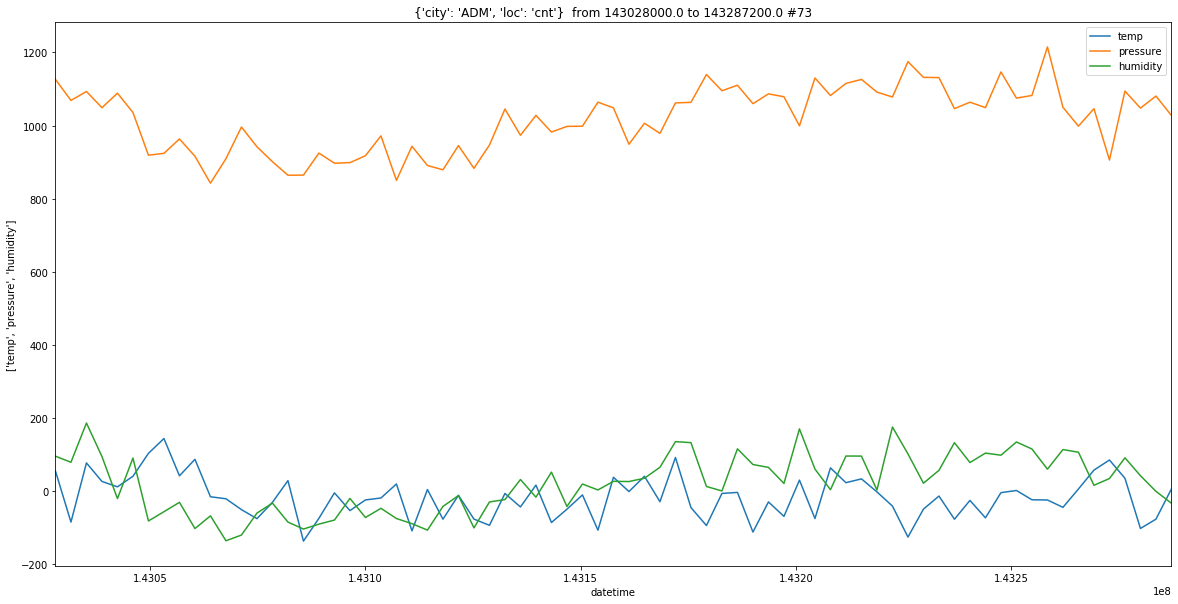

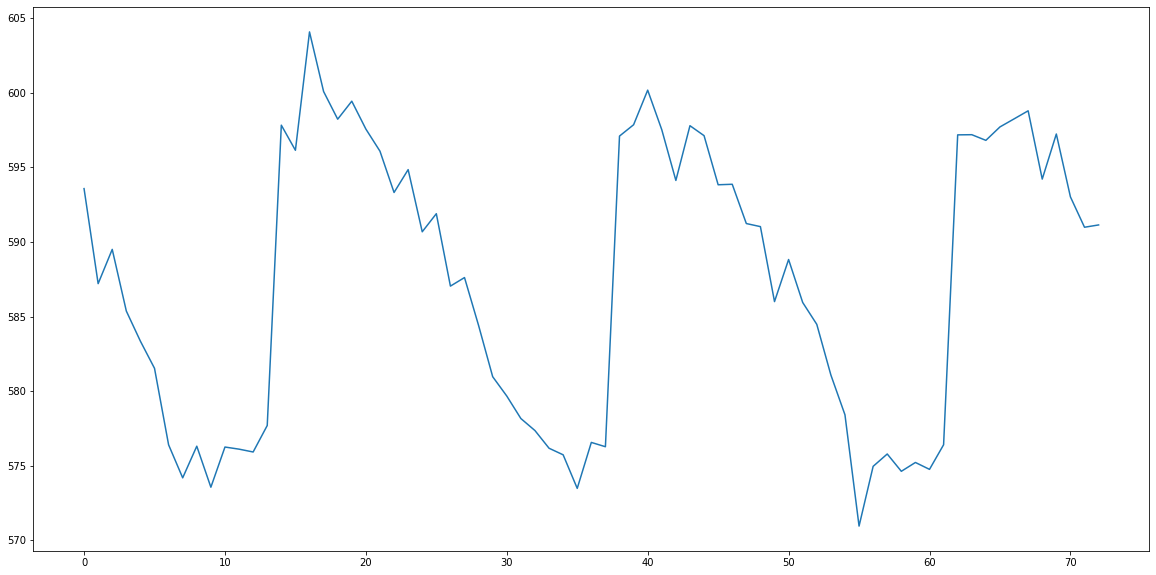

In [207]:
dbch.show_batch(max_n=1)

In [208]:
def emb_sz_rule(n_cat): 
    "Rule of thumb to pick embedding size corresponding to `n_cat`"
    return min(600, round(1.6 * n_cat**0.56))

def _one_emb_sz(classes, n, sz_dict=None):
    "Pick an embedding size for `n` depending on `classes` if not given in `sz_dict`."
    sz_dict = ifnone(sz_dict, {})
    n_cat = len(classes[n])
    sz = sz_dict.get(n, int(emb_sz_rule(n_cat)))  # rule of thumb
    return n_cat,sz

def get_emb_sz(to, sz_dict=None):
    "Get default embedding size from `TabularPreprocessor` `proc` or the ones in `sz_dict`"
    return [_one_emb_sz(to.procs.classes, n, sz_dict) for n in to.cat_names]

In [209]:
print(dbch.tfms[0][1].vocab)
emb_sz = [(n,emb_sz_rule(n)) for n in dbch.tfms[0][1].get_vocab_sz()]
print(emb_sz)

{'city': {0: 'ADM', 1: 'RTD', 2: 0}, 'loc': {0: 'rzb', 1: 'ctl', 2: 'cnt', 3: 'blm', 4: 0}}
[(3, 3), (5, 4)]


In [210]:
class LSTM(Module):
    initrange=0.1

    def __init__(self, emb_szs, n_in, n_hid, n_layers,n_out):
        store_attr(self, 'emb_szs,n_hid,n_layers')
        # not going to use embeddings for now
        self.emb = nn.ModuleList([nn.Embedding(emb_sz[0], emb_sz[1]) for emb_sz in emb_szs ])
        n_emb = sum(e.embedding_dim for e in self.emb)
        self.bn = nn.BatchNorm1d(n_in)
        self.bn.bias.data.fill_(1e-3)
        self.bn.weight.data.fill_(1)
        self.bn2 = nn.BatchNorm1d(n_hid)
        self.w_rnn = nn.Parameter(Tensor([0]*n_out))
        self.w_in = nn.Parameter(Tensor([1]*n_in))
        input_sz = n_in # + np.sum([emb_sz[0] for emb_sz in emb_szs ])
        self.rnn = nn.LSTM(input_sz, n_hid, n_layers-1, batch_first=True)         
        self.last_layer = nn.Conv1d(n_hid + n_emb, n_out, 1)
        self.out=[]
       
    def track_out(self,x):
        o = x.cpu().detach().numpy()
        self.out.append({'mean':np.float(o.mean()),'std':np.float(o.std())})
                
    def forward(self, x):
        con, cats = x
        cats = [e(cats[:,i]) for i,e in enumerate(self.emb)]
        cats = torch.cat(cats, 1)[:,:,None] 
        cats = torch.ones(con.shape[0],cats.shape[1],con.shape[1]).to(device)*cats
#         print(con.shape)
        con = self.bn(con.transpose(1,2)).transpose(1,2)
        raw_output = self.rnn(con)[0].transpose(1,2)
        raw_output = self.bn2(raw_output)
        self.track_out(raw_output)
#         print(raw_output.shape,cats.shape)
        raw_output = torch.cat([raw_output, cats], 1)
#         print(raw_output.shape)
        o = self.last_layer(raw_output).transpose(1,2)
#         print(self.emb(x[:,0,-2].long()))
        return o  


mdl = LSTM(emb_sz, 4, 8, 2, 1).to(device)
b = dbch.one_batch()
out = mdl(b[0])
print(out.shape)


torch.Size([64, 73, 1])


In [211]:
[o for o in mdl.out]

[{'mean': 1.6330039542822306e-09, 'std': 0.9996564388275146}]

In [212]:
learn = Learner(dbch, LSTM(emb_sz, 4, 8, 2, 1), loss_func=mse, opt_func=RAdam, metrics=[mae])

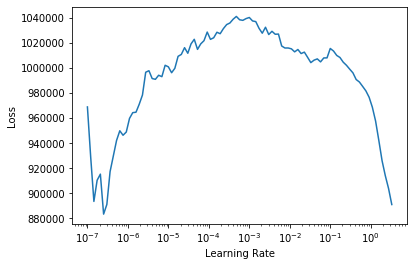

In [213]:
learn.lr_find()

In [214]:
learn.out = []

In [215]:
learn.fit_one_cycle(3, 5e-2)

epoch,train_loss,valid_loss,mae,time
0,1208541.500000,1078272.875000,1018.732788,00:05
1,974025.687500,726605.125000,835.652649,00:05
2,796140.187500,643659.187500,786.135620,00:05


In [220]:
learn.validate()

(#2) [643659.1875,786.1356201171875]

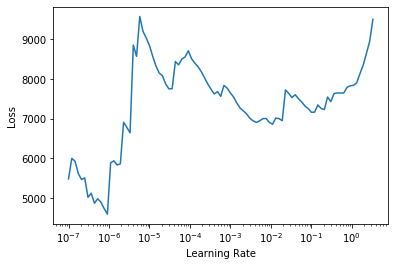

In [226]:
learn.lr_find()

In [222]:
learn.fit_one_cycle(1, 5e-1)

epoch,train_loss,valid_loss,mae,time
0,126366.742188,5590.138184,55.380779,00:06


In [227]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,mae,time
0,7551.706055,4661.611816,47.544926,00:05
1,7317.598145,5017.905762,49.435799,00:06
2,7100.599609,4892.289551,49.017410,00:06
3,7683.267578,4952.177246,49.301247,00:07
4,7709.092773,4884.109375,48.989010,00:06
5,7809.929688,4817.929199,48.589489,00:06
6,7618.804199,4862.921875,48.855831,00:06
7,7565.908203,4992.647949,49.331352,00:05
8,7652.469727,4715.951660,47.962227,00:06
9,7575.845215,5022.358887,49.442570,00:06


In [228]:
df = pd.DataFrame(learn.model.out)

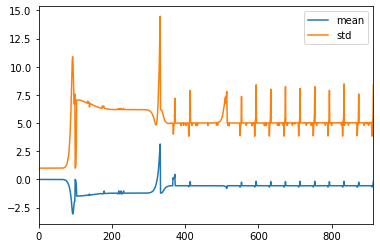

In [229]:
df.plot()

In [219]:
learn.show_results(max_n=1)

TypeError: mse() got an unexpected keyword argument 'reduction'